# Compare shape metrics

Compare all measured shape metric and explore them and their potential relationships.

In [12]:
import os
os.environ['USE_PYGEOS'] = '0'

import geopandas
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from palettable.cartocolors.qualitative import Bold_6

Set default plotting theme.

In [13]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

Load the data and combine them to a single GeoDataFrame.

In [14]:
sample = geopandas.read_parquet("../data/sample.parquet")

all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)


Check the total count.

In [18]:
all_poly_data.shape[0]

3440838

Check the distribution per continent.

In [19]:
all_poly_data.continent.value_counts() / all_poly_data.shape[0]

continent
North America    0.256376
South America    0.230353
Europe           0.166988
Africa           0.143184
Asia             0.134449
Oceania          0.068651
Name: count, dtype: float64

And a mean number o

In [21]:
all_poly_data.name.value_counts().mean()

26265.93893129771

Possible plot comparing two metrics.

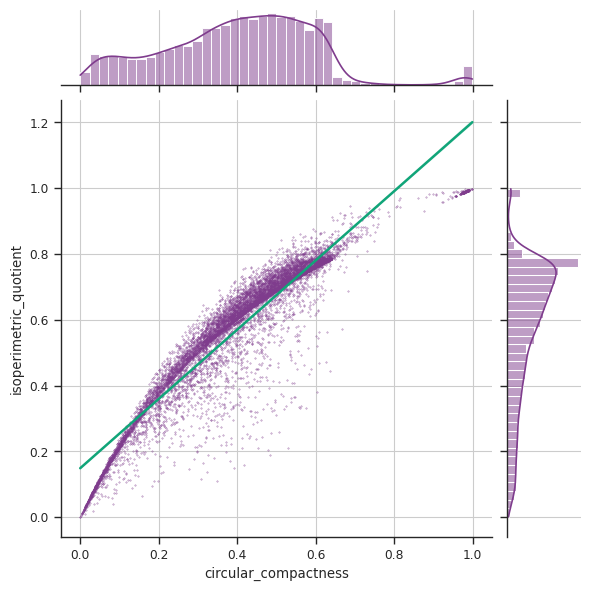

In [22]:
sns.jointplot(
    x="circular_compactness",
    y="isoperimetric_quotient",
    data=all_poly_data.sample(10000, random_state=42),
    kind="reg",
    scatter_kws=dict(s=0.1),
    line_kws=dict(color=Bold_6.mpl_colors[1]),
)

Plot comparing each pair of metrics.

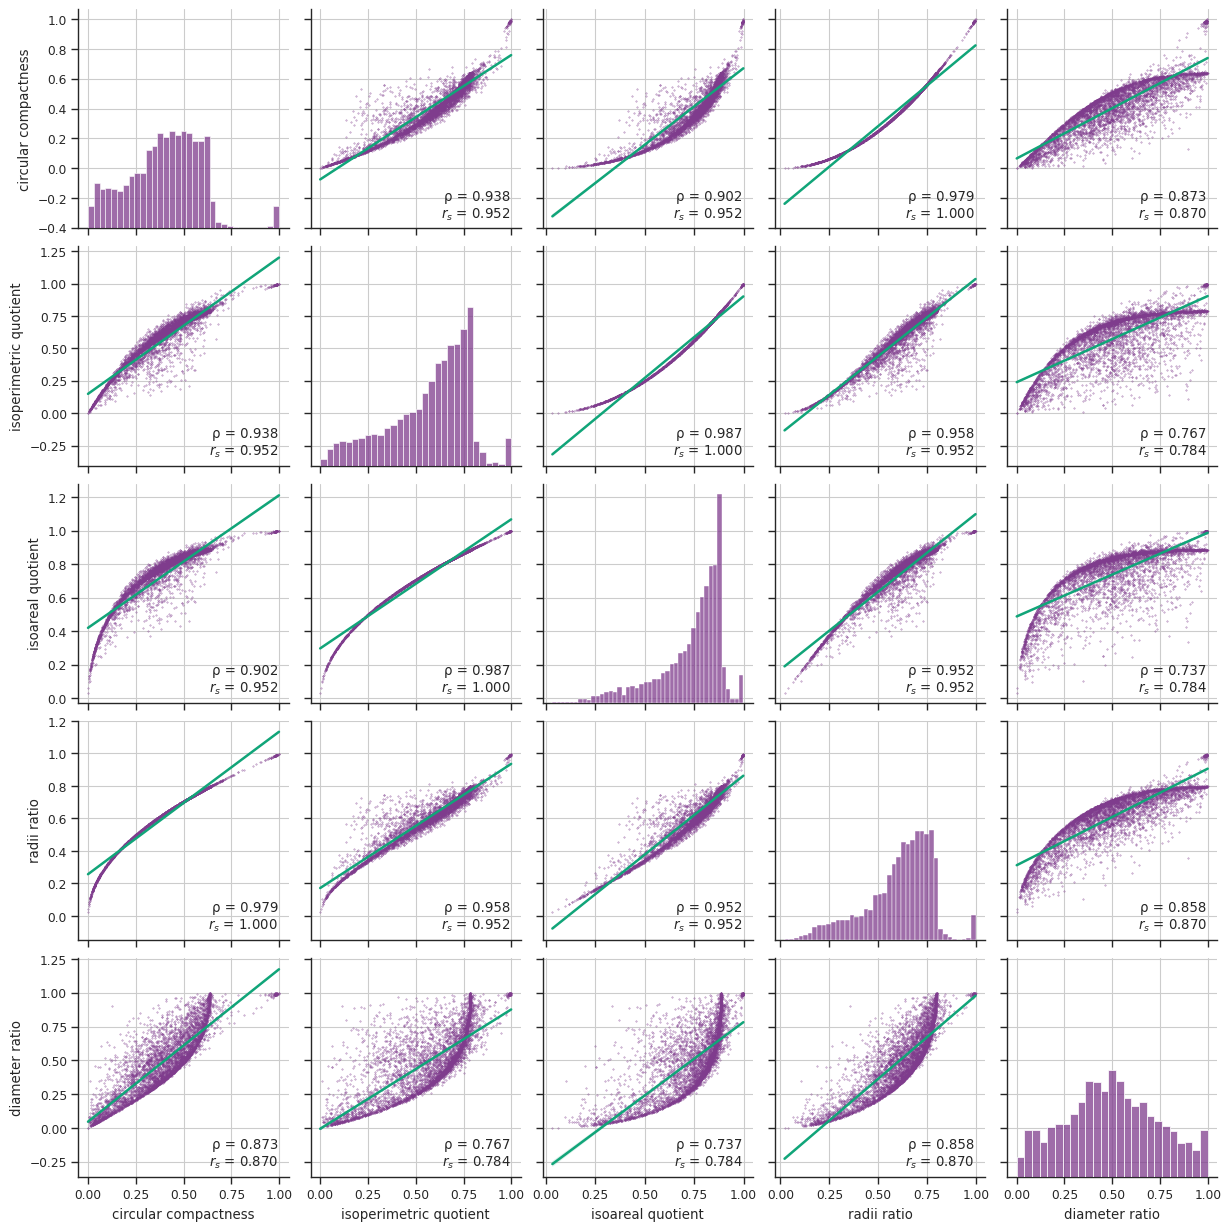

In [37]:
def annotator(x, y, ax=None, **kws):
    """Plot the correlation coefficients in the top left corner of a plot."""
    r, _ = scipy.stats.pearsonr(x, y)
    s, _ = scipy.stats.spearmanr(x, y)
    ax = ax or plt.gca()
    ax.annotate(
        (
            f"ρ = {r:.3f}\n"
            "$r_{s}$ = "
            f"{s:.3f}"
        ), 
        xy=(.95, .05), 
        horizontalalignment="right",
        xycoords=ax.transAxes,
    )

pp = sns.pairplot(
    all_poly_data[
        [
            "circular_compactness",
            "isoperimetric_quotient",
            "isoareal_quotient",
            "radii_ratio",
            "diameter_ratio",
        ]
    ].sample(5000, random_state=42).rename(
        columns={c:c.replace("_", " ") for c in all_poly_data.columns}
    ),
    kind="reg",
    plot_kws=dict(
        scatter_kws=dict(s=0.1),
        line_kws=dict(color=Bold_6.mpl_colors[1]),
        truncate=True,
        seed=42,
    ),
)
pp.map_offdiag(annotator)
plt.savefig("../plots/shapes/comparison.png", dpi=300, bbox_inches="tight")

Measure Pearson's correlation

In [9]:
pearson = all_poly_data[
    [
        "circular_compactness",
        "isoperimetric_quotient",
        "isoareal_quotient",
        "radii_ratio",
        "diameter_ratio",
    ]
].corr()
pearson.to_csv("../results/pearson.csv")
print(pearson.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
 & circular_compactness & isoperimetric_quotient & isoareal_quotient & radii_ratio & diameter_ratio \\
\midrule
circular_compactness & 1.000 & 0.938 & 0.903 & 0.979 & 0.874 \\
isoperimetric_quotient & 0.938 & 1.000 & 0.987 & 0.958 & 0.765 \\
isoareal_quotient & 0.903 & 0.987 & 1.000 & 0.952 & 0.735 \\
radii_ratio & 0.979 & 0.958 & 0.952 & 1.000 & 0.858 \\
diameter_ratio & 0.874 & 0.765 & 0.735 & 0.858 & 1.000 \\
\bottomrule
\end{tabular}



Measure Spearman's correlation

In [10]:
spearman = all_poly_data[
    [
        "circular_compactness",
        "isoperimetric_quotient",
        "isoareal_quotient",
        "radii_ratio",
        "diameter_ratio",
    ]
].corr("spearman")
spearman.to_csv("../results/spearman.csv")
print(spearman.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
 & circular_compactness & isoperimetric_quotient & isoareal_quotient & radii_ratio & diameter_ratio \\
\midrule
circular_compactness & 1.000 & 0.952 & 0.952 & 1.000 & 0.872 \\
isoperimetric_quotient & 0.952 & 1.000 & 1.000 & 0.952 & 0.785 \\
isoareal_quotient & 0.952 & 1.000 & 1.000 & 0.952 & 0.785 \\
radii_ratio & 1.000 & 0.952 & 0.952 & 1.000 & 0.872 \\
diameter_ratio & 0.872 & 0.785 & 0.785 & 0.872 & 1.000 \\
\bottomrule
\end{tabular}



## Shape + area indices

Explore distribution of indices capturing relationship between shape metrics and area.

<AxesSubplot: ylabel='Frequency'>

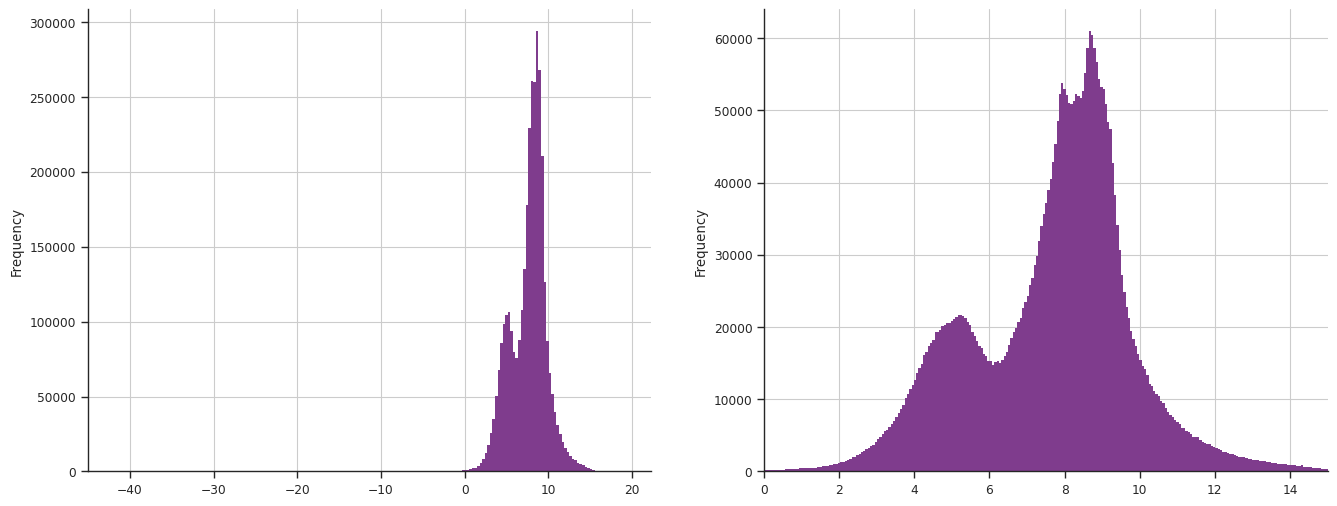

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.circular_compactness_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.circular_compactness_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

<AxesSubplot: ylabel='Frequency'>

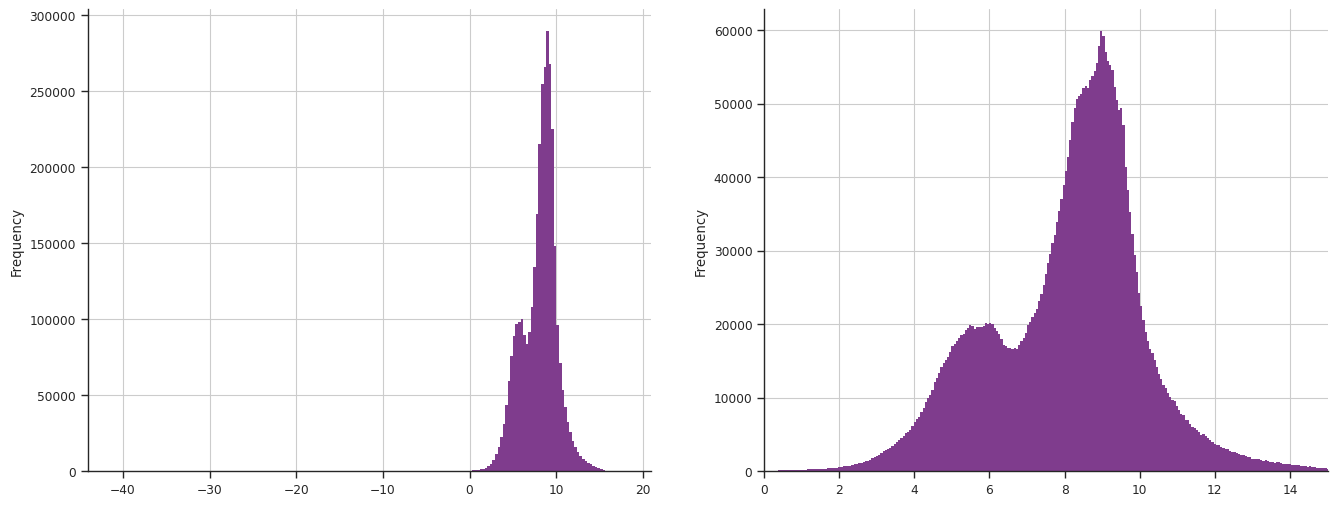

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.isoperimetric_quotient_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.isoperimetric_quotient_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

<AxesSubplot: ylabel='Frequency'>

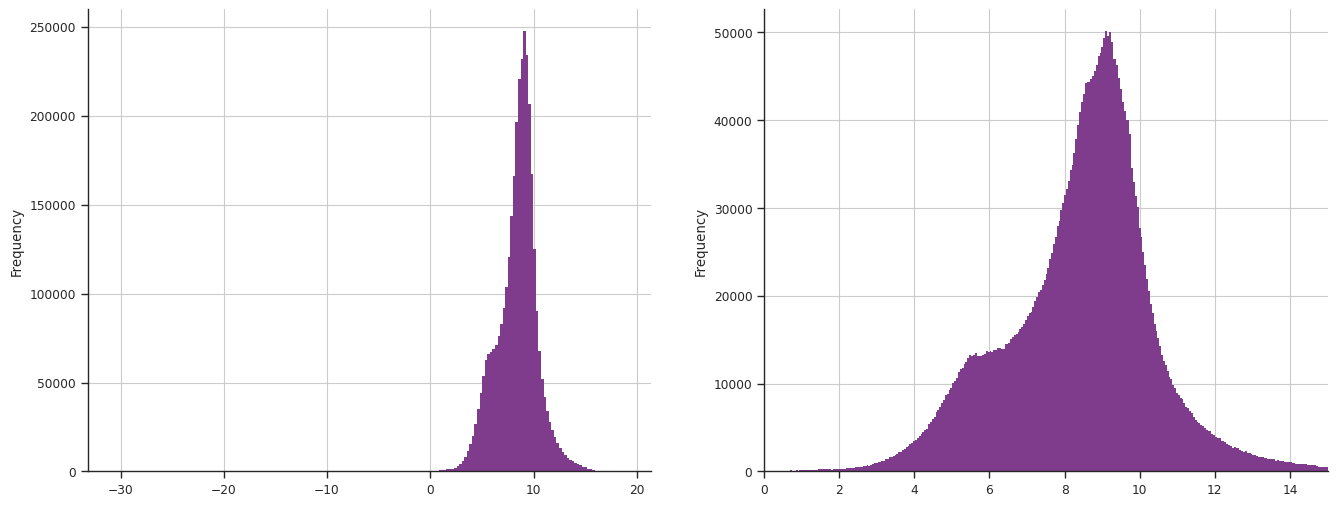

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.isoareal_quotient_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.isoareal_quotient_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

<AxesSubplot: ylabel='Frequency'>

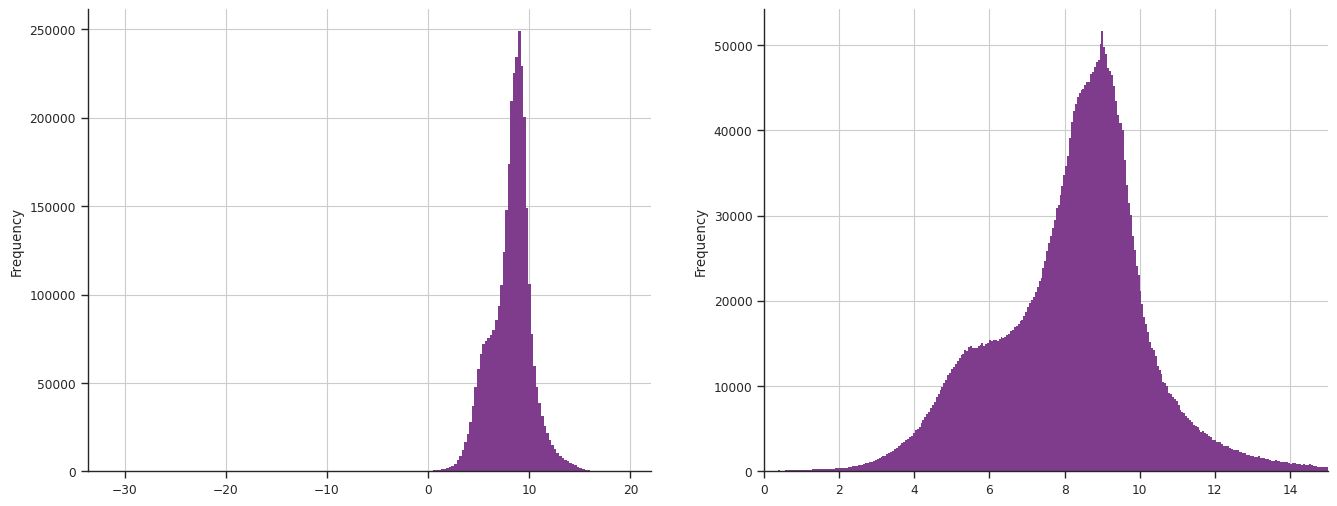

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.radii_ratio_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.radii_ratio_index).plot.hist(bins=1000, xlim=(0, 15), ax=axs[1])


<AxesSubplot: ylabel='Frequency'>

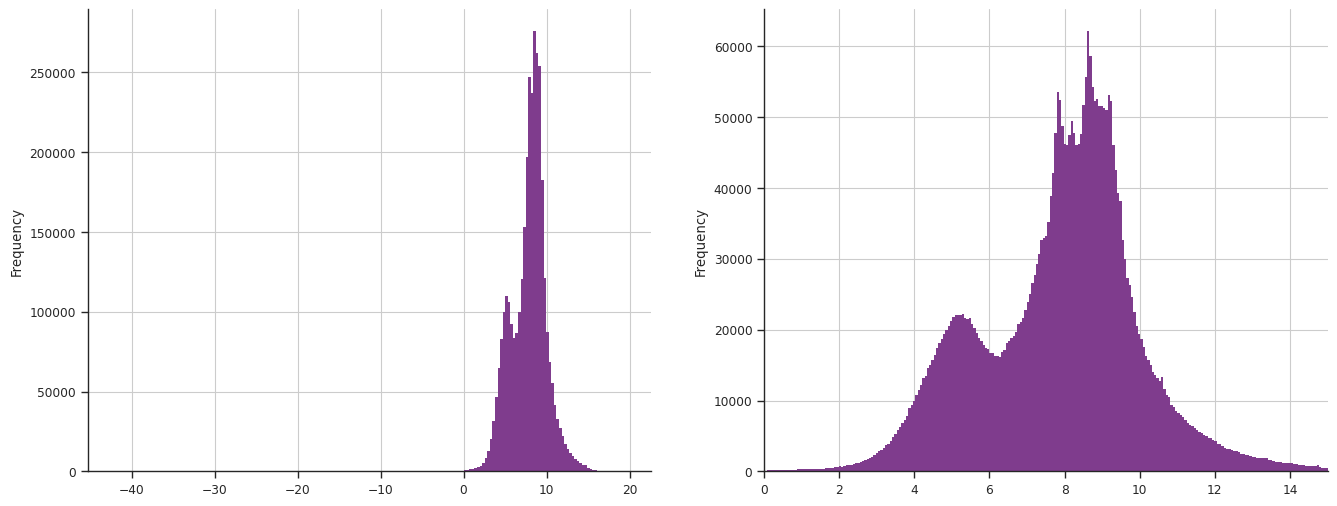

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

numpy.log(all_poly_data.diameter_ratio_index).plot.hist(bins=200, ax=axs[0])
numpy.log(all_poly_data.diameter_ratio_index).plot.hist(
    bins=1000, xlim=(0, 15), ax=axs[1]
)

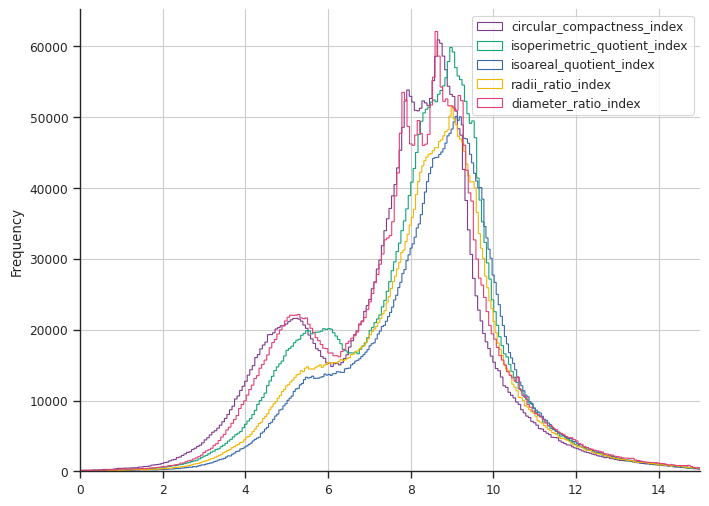

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
for ix in [c for c in all_poly_data.columns if "index" in c]:
    numpy.log(all_poly_data[ix]).plot.hist(
        bins=1000, xlim=(0, 15), ax=ax, histtype="step"
    )
plt.legend()